In [11]:
# Hi, welcome to my notebook, we will go through some methods to rank feature for classification problem
# They are: Filter method, Wrapper, Tree-based and Other ML methods
# Also, to understand if the model perform well under ranking task, we tempted to use wrapper method to verify it. 
# To be specific, we will try to use 80% of the dataset for ranking with tree-based and ML models, then we will use 20% test set to verify if the ranking brings us some insights or not.
# Since the wrapper method depends solely on the target model (tree-based and ML), it might not be a good idea to compare them unless we have a standard model for the classification task.
# At the end, the author attempt to find the meaning of ranking features, therefore, he used a very simple logistic regression to classify the dataset after ranking. 
# It is the author's idea to multiply the ranking score to the dataset as before feeding to the logistic regression.
# I hope you have fun reading it.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import ppscore as pps

In [2]:
from treeranker import my_tree_ranker
from svmranker import my_svm_ranker
from judge import my_judge

In [3]:
df = pd.read_csv("task_data.csv")
df.head()

,sample index,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
0,sample0,1.0,0.834251,0.726081,0.535904,0.214896,0.873788,0.767605,0.111308,0.557526,0.599650,0.665569
1,sample1,1.0,0.804059,0.253135,0.869867,0.334285,0.604075,0.494045,0.833575,0.194190,0.014966,0.802918
2,sample2,1.0,0.694404,0.595777,0.581294,0.799003,0.762857,0.651393,0.075905,0.007186,0.659633,0.831009
3,sample3,1.0,0.783690,0.038780,0.285043,0.627305,0.800620,0.486340,0.827723,0.339807,0.731343,0.892359
4,sample4,1.0,0.788835,0.174433,0.348770,0.938244,0.692065,0.377620,0.183760,0.616805,0.492899,0.930969


In [4]:
def write_output(content, filepath):
    '''
    Write out the ranking to txt file
    :param content: list
    :param filepath: directory of the output file
    :return True
    '''
    try:
        file_object = open(filepath,"w")
        for item in content:
            _temp = item[1] + ": " + str(item[0])
            file_object.write(_temp)
            file_object.write("\n")
        file_object.close()
        return True
    except:
        return -1    

<AxesSubplot:>

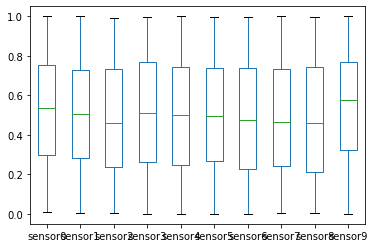

In [5]:
X_label = df.columns[2:]
Y_label = df.columns[1]
df[X_label].plot(kind = 'box')

In [6]:
df[X_label].describe()

,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.523661,0.509223,0.481238,0.509752,0.497875,0.501065,0.490480,0.482372,0.482822,0.541933
std,0.268194,0.276878,0.287584,0.297712,0.288208,0.287634,0.289954,0.282714,0.296180,0.272490
min,0.007775,0.003865,0.004473,0.001466,0.000250,0.000425,0.000173,0.003322,0.003165,0.000452
25%,0.299792,0.283004,0.235544,0.262697,0.249369,0.269430,0.226687,0.242848,0.213626,0.321264
50%,0.534906,0.507583,0.460241,0.510066,0.497842,0.497108,0.477341,0.463438,0.462251,0.578389
75%,0.751887,0.727843,0.734937,0.768975,0.743401,0.738854,0.735304,0.732483,0.740542,0.768990
max,0.999476,0.998680,0.992963,0.995119,0.999412,0.997367,0.997141,0.998230,0.996098,0.999465


In [7]:
from scipy.stats import shapiro
p_value = []
for i in X_label:
    stat, p = shapiro(df[i])
    p_value.append(p)
p_value

[5.9069378721687826e-08,
 5.1171035408970056e-08,
 1.1025628188221503e-09,
 8.590767680560774e-11,
 1.6595369523031422e-09,
 1.1086714879482429e-09,
 1.7267766105888427e-09,
 1.3327611236846337e-09,
 9.885936513853721e-11,
 5.400383251696894e-09]

In [8]:
# With p values < 0.05, we fail to reject that 10 features are Gaussian distributed

In [9]:
# Standardization of dataset
from sklearn.preprocessing import StandardScaler
standardized = StandardScaler().fit(df[X_label])
data_standardized = standardized.transform(df[X_label])

In [10]:
temp = pd.DataFrame(data_standardized, columns = X_label)
temp.head()

,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
0,1.159533,0.784209,0.190322,-0.991648,1.305944,0.927822,-1.309333,0.266167,0.394942,0.454293
1,1.046817,-0.926072,1.353050,-0.590123,0.368943,-0.024436,1.184756,-1.020618,-1.581615,0.958976
2,0.637440,0.312997,0.348354,0.972798,0.920561,0.523290,-1.431585,-1.682906,0.597719,1.062195
3,0.970771,-1.701231,-0.683073,0.395351,1.051752,-0.051257,1.164548,-0.504903,0.840140,1.287622
4,0.989982,-1.210676,-0.461201,1.441087,0.674625,-0.429712,-1.059149,0.476105,0.034065,1.429494


In [11]:
df = df[df.columns[:2]]
df = df.join(temp)
df.head()

,sample index,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
0,sample0,1.0,1.159533,0.784209,0.190322,-0.991648,1.305944,0.927822,-1.309333,0.266167,0.394942,0.454293
1,sample1,1.0,1.046817,-0.926072,1.353050,-0.590123,0.368943,-0.024436,1.184756,-1.020618,-1.581615,0.958976
2,sample2,1.0,0.637440,0.312997,0.348354,0.972798,0.920561,0.523290,-1.431585,-1.682906,0.597719,1.062195
3,sample3,1.0,0.970771,-1.701231,-0.683073,0.395351,1.051752,-0.051257,1.164548,-0.504903,0.840140,1.287622
4,sample4,1.0,0.989982,-1.210676,-0.461201,1.441087,0.674625,-0.429712,-1.059149,0.476105,0.034065,1.429494


In [12]:
df.describe()

,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
count,400.000000,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02
mean,0.000000,1.776357e-16,-7.105427e-17,-7.993606e-17,2.131628e-16,-2.131628e-16,-2.664535e-16,-9.325873e-17,3.552714e-17,-7.105427e-17,7.993606e-17
std,1.001252,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00
min,-1.000000,-1.925967e+00,-1.827489e+00,-1.659907e+00,-1.709447e+00,-1.728781e+00,-1.742725e+00,-1.693099e+00,-1.696592e+00,-1.621508e+00,-1.989650e+00
25%,-1.000000,-8.357716e-01,-8.180611e-01,-8.554089e-01,-8.308832e-01,-8.633255e-01,-8.063200e-01,-9.109152e-01,-8.482919e-01,-9.100342e-01,-8.108412e-01
50%,0.000000,4.198384e-02,-5.930459e-03,-7.310365e-02,1.054419e-03,-1.162079e-04,-1.377269e-02,-4.537227e-02,-6.705339e-02,-6.954421e-02,1.339549e-01
75%,1.000000,8.520422e-01,7.905779e-01,8.832751e-01,8.718063e-01,8.529713e-01,8.277425e-01,8.454108e-01,8.857899e-01,8.712381e-01,8.343084e-01
max,1.000000,1.776369e+00,1.769988e+00,1.781621e+00,1.632366e+00,1.742368e+00,1.727624e+00,1.749571e+00,1.826953e+00,1.735158e+00,1.681181e+00


Text(0.5, 1.0, 'Correlation matrix')

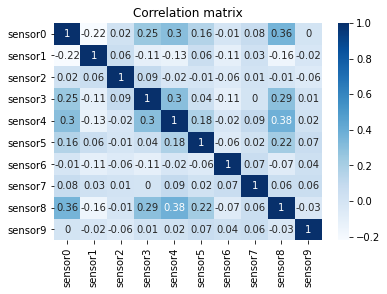

In [13]:
corr=df[df.columns[2:]].corr()
sns.heatmap(corr.round(2), cmap = 'Blues', annot = True).set_title('Correlation matrix', fontsize = 12)

In [16]:
#Filter methods are ANOVA and Predictive Power Score (PPS).
#Advantage of ANOVA: it is also simple to calculate, and is used to test the interaction hypotheses between features.
#Disadvantage: we should have a normalized dataset to work on, meaning a uniform distributed dataset, with the same mean and standard variance. It is not the case in this dataset 

In [17]:
#Advantage of PPS: it can learn also the non-linear relationship between features.
#Disadvantage: Slower calculation
#https://github.com/8080labs/ppscore


In [18]:
# In this part, we try to rank features using tree-based model and ML model, then we want to verify the ranked features with the same model.
# We tempted to use wrapper method (Permutation Importance) for the verification, the idea is: if an important feature get destroyed, the performance of the model should decrease.

In [19]:
# Tree-based method or intrinsic method
# It is based on Mean decrease of impurity.
# For this test, we will be using the queen of the trees XGBClassifier

In [20]:
df.to_csv("new_task_data.csv")

In [21]:
test = pd.read_csv("new_task_data.csv")
test.head()

,Unnamed: 0,sample index,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
0,0,sample0,1.0,1.159533,0.784209,0.190322,-0.991648,1.305944,0.927822,-1.309333,0.266167,0.394942,0.454293
1,1,sample1,1.0,1.046817,-0.926072,1.353050,-0.590123,0.368943,-0.024436,1.184756,-1.020618,-1.581615,0.958976
2,2,sample2,1.0,0.637440,0.312997,0.348354,0.972798,0.920561,0.523290,-1.431585,-1.682906,0.597719,1.062195
3,3,sample3,1.0,0.970771,-1.701231,-0.683073,0.395351,1.051752,-0.051257,1.164548,-0.504903,0.840140,1.287622
4,4,sample4,1.0,0.989982,-1.210676,-0.461201,1.441087,0.674625,-0.429712,-1.059149,0.476105,0.034065,1.429494


(320, 10) (320,)
(80, 10) (80,)
[15:02:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/home/tung/environment/tensorflow2/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


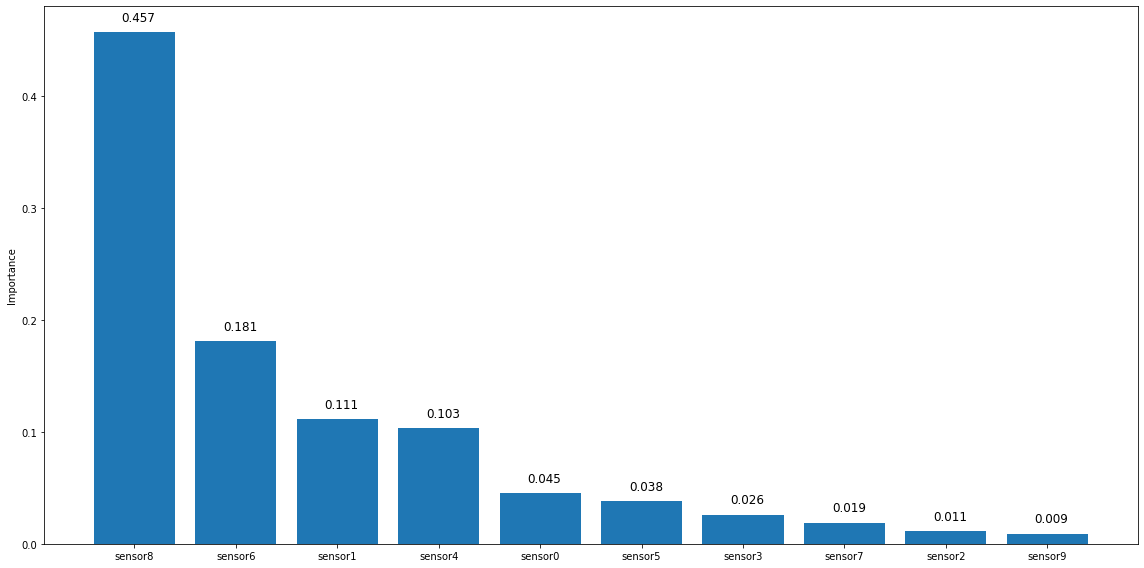

[-0.008125 -0.003125  0.       -0.01375   0.0025    0.        0.271875
  0.        0.02625   0.      ]


True

In [22]:
my_tree = my_tree_ranker("new_task_data.csv")
my_tree.dataLoader([3,4,5,6,7,8,9,10,11,12],2,0.8)
my_tree.train()
tree_content = my_tree.report()
my_tree.permutation()

write_output(tree_content,"tree_ranking.txt")

In [23]:
# Verify the ranked feature of XGBClassifier with Permutation Features
my_tree.permutation()

[-0.008125 -0.0025    0.       -0.010625 -0.00125   0.        0.259375
  0.        0.025625  0.      ]


Weight,Feature
0.2594 ± 0.0580,sensor6
0.0256 ± 0.0349,sensor8
0 ± 0.0000,sensor9
0 ± 0.0000,sensor7
0 ± 0.0000,sensor5
0 ± 0.0000,sensor2
-0.0012 ± 0.0261,sensor4
-0.0025 ± 0.0100,sensor1
-0.0081 ± 0.0119,sensor0
-0.0106 ± 0.0143,sensor3


In [24]:
# Interpreting the table
# Top down fashion, features have decreasing in importance when being shuffled.
# The first number is the model performance and the second one is the randomness.

In [25]:
#Advantages
#It is immune to multicollinearity of the dataset
#It is the perfect algo for this situation, since we only have 2 classes and small dataset of 400 samples, it also calculates fast
#It can avoid overfitting by pruning trees and using regularization L1.
#It can work with a sparse dataset.

#Disadvantages:
#Its downside is when we have a more complicated dataset, with more classes, more features, its performance decreases due to overfitting.
#It also depends on outliners to make decisions, it is due to its nature to try to correct each predecessor tree.
#It uses a sequential process to train trees, so it is time consuming. 

#Verification with wrapper method: there is a small conflict in ranking with the dataset, in which the most important ones are sensors 6, 8 and 4. In order to understand this further, and in order to be fair, we should dive into what makes our train and test sets. To be fair, the train and test sets must follow the same distribution. In this case, we random shuffle the dataset, and the problem could be: in our test set, the number of sample depends on feature 6 higher than feature 8. We can see that, with XGBClassifier, we can tell that sensors 8 and 6 are more important than other in classifying the class using XGBClassifier.

#Another method to be considered here: Random forest tree, it is also included in the code, for the task of calculating feature importances, they share similarity in the idea behind. One point here is it is a bagging model, so it can be better than XGBClassifier in avoiding overfitting. Comparison between the two methods is controversial.

In [26]:
# Other ML method
# SVM is powerful in classification, and using soft SVM, we try to classify our dataset, based on the 10 sensors. 
# The sensors are ranked on their coefficients.

(320, 10) (320,)
(80, 10) (80,)


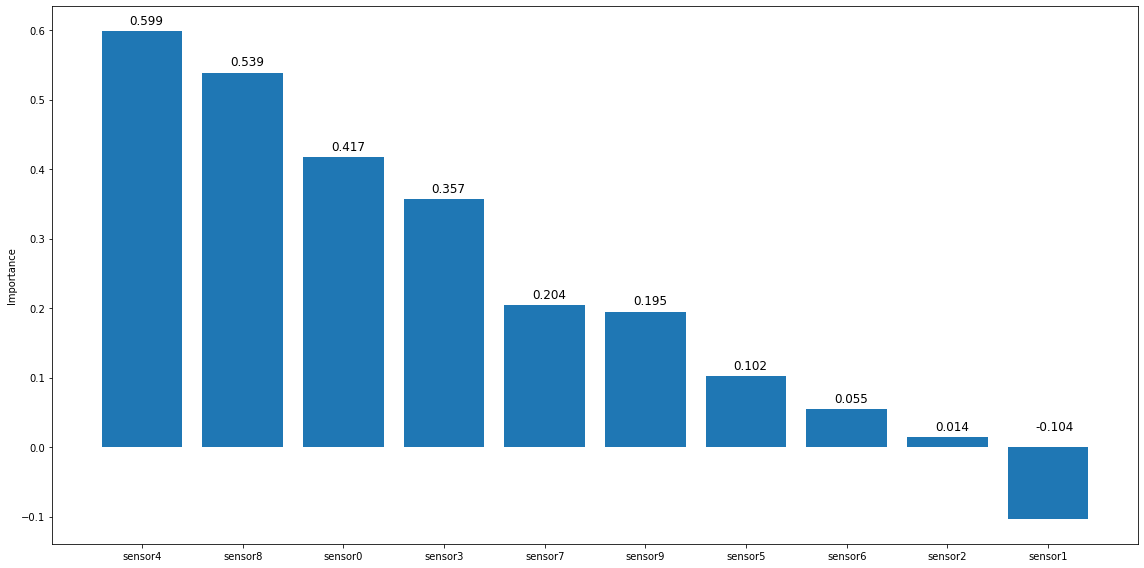

[ 0.045    -0.000625  0.        0.005625  0.07375  -0.004375  0.
 -0.008125  0.089375  0.00375 ]


True

In [27]:
my_svm = my_svm_ranker("new_task_data.csv")
my_svm.dataLoader([3,4,5,6,7,8,9,10,11,12],2,0.8)
my_svm.train()
svm_content = my_svm.report()
my_svm.permutation()

write_output(svm_content, "svm_ranking.txt")

In [28]:
# Verify with permutation importance
my_svm.permutation()

[ 0.04125   0.004375  0.        0.00125   0.071875 -0.003125  0.
 -0.001875  0.090625  0.001875]


Weight,Feature
0.0906 ± 0.0569,sensor8
0.0719 ± 0.0627,sensor4
0.0412 ± 0.0554,sensor0
0.0044 ± 0.0163,sensor1
0.0019 ± 0.0288,sensor9
0.0012 ± 0.0284,sensor3
0 ± 0.0000,sensor6
0 ± 0.0000,sensor2
-0.0019 ± 0.0198,sensor7
-0.0031 ± 0.0108,sensor5


In [29]:
#Advantages:
#It is relatively powerful in classification tasks, even in case of not-so-clear margin, we can use soft SVM.
#It can avoid overfitting with margin trade off.
#It works well with high dimensional data.
#It is shown to be memory efficient also. 

#Disadvantages:
#With a larger dataset, we might have a computational problem.
#Also, the output of SVM depends on our choice of kernels.
#And its output is not a probability, so it is not easy to interpret for classification problems.

#Verification with wrapper method: there is a small conflict in ranking with the dataset, in which the most important ones are sensors 8, 4 and 0. This problem could be explained similarly as the above XGBClassifier. We can see that, with soft SVM, we can tell that sensors 8 and 4 are more important than other in classifying the class using soft SVM.

#SVM uses kernel trick to work around with high dimensional dataset, hence it is scalable in term of number of features. However, in term of number of samples, it is not the case, because increasing the number of samples can lead to overlap between regions due to outliers, and the margin is not easy to find.



In [30]:
#Wrapper method
#Advantages:
#This method works well in destroying each feature and discovering the accuracy of the model in each turn.
#It could be ideal to verify the ranked feature regarding to the host model. 

#Disadvantages:
#Since it is a repeated process, time is a factor to be considered, and it might not be a good idea to apply for a dataset with many features.

#Wrapper method is an iterative method in interferencing the features, assume the time complexity is O(#feature), it is hence not scalable to the number of features. To the number of samples, I believe increasing the number of sampling would not corrupt the model.
 
#Another wrapper method is Recursive Feature Elimination. This method returns the accuracy of the corresponding models without each feature. It also shares the similarities in advantages and disadvantages. Other ML method: Lasso, with L1, it can punish features, therefore, it is well known for the ability to select good features.


In [31]:
## Problems
# During working, one mistake encounterred is: data is not shuffled. 
# The output of the host model and the wrapper method got huge conflict.

In [32]:
## Conclusion
# We have been through some methods in all the group.
# It is difficult to conclude which ranking is better than others, however, from all the ranking results, we can tell that sensor 8 is important to classify classes.

In [33]:
## Addition

In [34]:
# Ranking with Predictive Power Score

In [29]:
rank = []
cols = df.columns
sensors = df.columns[2:]
for c in sensors:
    rank.append(round(pps.score(df,c,cols[1])["ppscore"],3))

In [30]:
type(rank), type(sensors)

(list, pandas.core.indexes.base.Index)

In [31]:
def report(rank, sensors, top = 10, plot = True):
        '''
        Report the ranking list
        Show the bar plot

        :param top: number of top elements, default = 11
        :param plot: show bar plot, default True
        :return rank: ranking 
        :exception: return -1
        '''
        # Get coefficience as the metrics to evaluate ranking
        result = sorted(zip(map(lambda x: round(x,3), 
                      rank), sensors), reverse=True)
        if plot:
            importance = list(zip(*result))[0][:top]
            sensor = list(zip(*result))[1][:top]

            fig = plt.figure(figsize = (16,8))
            sensor = list(zip(*result))[1][:top]
            value = list(zip(*result))[0][:top]
            plt.bar(sensor, value, align="center")
            plt.ylabel("Importance")
            for idx, val in enumerate(value):
                if val > 0:
                    plt.text(x = idx - 0.125 , y = val + 0.01, s = str(val) , fontdict = dict(fontsize=12))
                else:
                    plt.text(x = idx - 0.125 , y = 0.025, s = str(val) , fontdict = dict(fontsize=12))
            plt.tight_layout()
            plt.show()
        return result

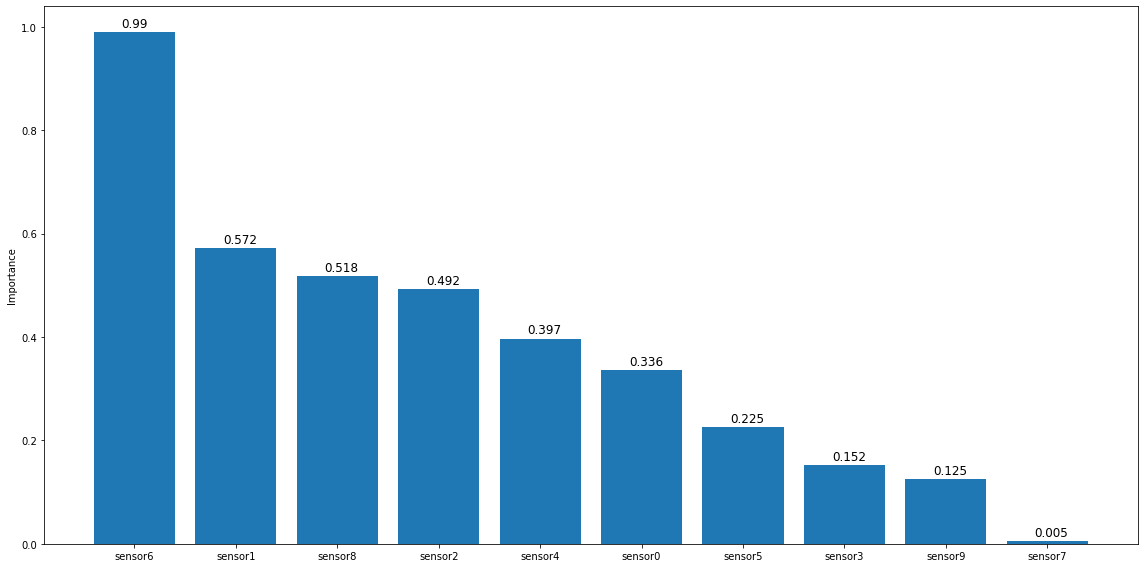

In [32]:
pps_content = report(rank,sensors)

In [33]:
write_output(pps_content,"pps_ranking.txt")

True

In [34]:
# In order to verify if the ranking is useful to the final task of classification, the author idea is to multiply the normalized ranking to the values of sensors, then feed their values to a neutral classifier.
# Normalization ranking will give the most important feature coefficience 1 while the least important is 0
# The neutral classifier should not be a NN, since with NN, it will not require feature engineering, and the author believes it is fairer with a very basic ML model.
# So we will go with a logistic regression. With keras, it can be implemented as 2-layer NN. The output layer will have 2 neurons.
# The model is then tuned with adam optimizer, L2 regularization, the accuracy of all the PPS ranked methods turn to be 1 and 0 error. 
# Since it brings no insights to the ranking systems, we will stop here. 
# The author believes the problem might comes from the habit of tuninng the logistic model. 
# The next attempt is with the built-in LogisticRegression of sklearn lib, since building one from scratch is time-consuming. And we can find something interesting here :).


In [35]:
test = test.drop("Unnamed: 0", axis=1)

In [36]:
# For XGBClassifier
judge_tree = my_judge()
tree_data = judge_tree.create_dataset(tree_content,test,0.8)
judge_tree.fitmodel()
judge_tree.report()

(320, 10) (320,)
(80, 10) (80,)
[(1.0, 'sensor8'), (0.384, 'sensor6'), (0.228, 'sensor1'), (0.21, 'sensor4'), (0.08, 'sensor0'), (0.065, 'sensor5'), (0.038, 'sensor3'), (0.022, 'sensor7'), (0.004, 'sensor2'), (0.0, 'sensor9')]
              precision    recall  f1-score   support

        -1.0       0.97      0.92      0.94        36
         1.0       0.93      0.98      0.96        44

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



(0.878125, 0.95)

In [37]:
judge_svm = my_judge()
svm_data = judge_svm.create_dataset(svm_content,test,0.8)
judge_svm.fitmodel()
judge_svm.report()

(320, 10) (320,)
(80, 10) (80,)
[(1.0, 'sensor4'), (0.915, 'sensor8'), (0.741, 'sensor0'), (0.656, 'sensor3'), (0.438, 'sensor7'), (0.425, 'sensor9'), (0.293, 'sensor5'), (0.226, 'sensor6'), (0.168, 'sensor2'), (0.0, 'sensor1')]
              precision    recall  f1-score   support

        -1.0       0.94      0.89      0.91        36
         1.0       0.91      0.95      0.93        44

    accuracy                           0.93        80
   macro avg       0.93      0.92      0.92        80
weighted avg       0.93      0.93      0.92        80



(0.9375, 0.925)

In [38]:
default_content = [*zip([1]*10,df.columns[2:])]

In [39]:
judge_default = my_judge()
default_data = judge_default.create_dataset(default_content,test,0.8)
judge_default.fitmodel()
judge_default.report()

(320, 10) (320,)
(80, 10) (80,)
[(1, 'sensor0'), (1, 'sensor1'), (1, 'sensor2'), (1, 'sensor3'), (1, 'sensor4'), (1, 'sensor5'), (1, 'sensor6'), (1, 'sensor7'), (1, 'sensor8'), (1, 'sensor9')]
              precision    recall  f1-score   support

        -1.0       0.94      0.86      0.90        36
         1.0       0.89      0.95      0.92        44

    accuracy                           0.91        80
   macro avg       0.92      0.91      0.91        80
weighted avg       0.91      0.91      0.91        80



(0.940625, 0.9125)

In [40]:
# There is a fun thing here, without ranking, the logistic regression performs better. It could mean that the dataset is easily to be separated. Also multiplying the rank back to the value leads to the decrease in their values, and might decrease the level of importance in logistic regression when multiplicating with weight matrix and lead to wrong decision.
# It can be seen that logistic regression output a more convincing result for the soft SVM than XGBClassifier.
# Test accuracy of XGBClassifier > train accuracy, and it could come from the bad train-test split, or the linear regression is underfitting, either way, the verification of soft SVM bring more insights in this case.
# Thank you.